# Scalar data splitter

Log energies but don't normalize them

In [1]:
import os
import time
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm
from matplotlib import pyplot as plt
from pprint import pprint

In [9]:
# Read things from .npz files
data_dir = "/usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/processed/scalar_test"
os.chdir(data_dir)

pions = dict(np.load("pi0_40-250GeV_100k.npz"))
photons = dict(np.load("pi0_40-250GeV_100k.npz"))
scalars = dict(np.load("pi0_40-250GeV_100k.npz"))

## Mix up all jets

In [10]:
# ~5 sec
# Concatenate pion, photon, and scalar jets into giant 300k thing
all_layers = {}
layers = ["energy", "layer_0", "layer_1", "layer_2", "layer_3", "overflow"]
for layer in layers:
    all_layers[layer] = np.concatenate([pions[layer], photons[layer], scalars[layer]], axis=0)

N = 100000
all_layers["label"] = np.array((0,) * N + (1,) * N + (2,) * N, dtype=int)

In [11]:
for layer in all_layers:
    print(layer.ljust(10), str(all_layers[layer].dtype).ljust(15), all_layers[layer].shape)

energy     float64         (300000, 1)
layer_0    float64         (300000, 4, 16)
layer_1    float64         (300000, 4, 128)
layer_2    float64         (300000, 16, 16)
layer_3    float64         (300000, 16, 8)
overflow   float64         (300000, 4)
label      int64           (300000,)


### Log-ify and scale energies

Processing layer_0
Processing layer_1
Processing layer_2
Processing layer_3


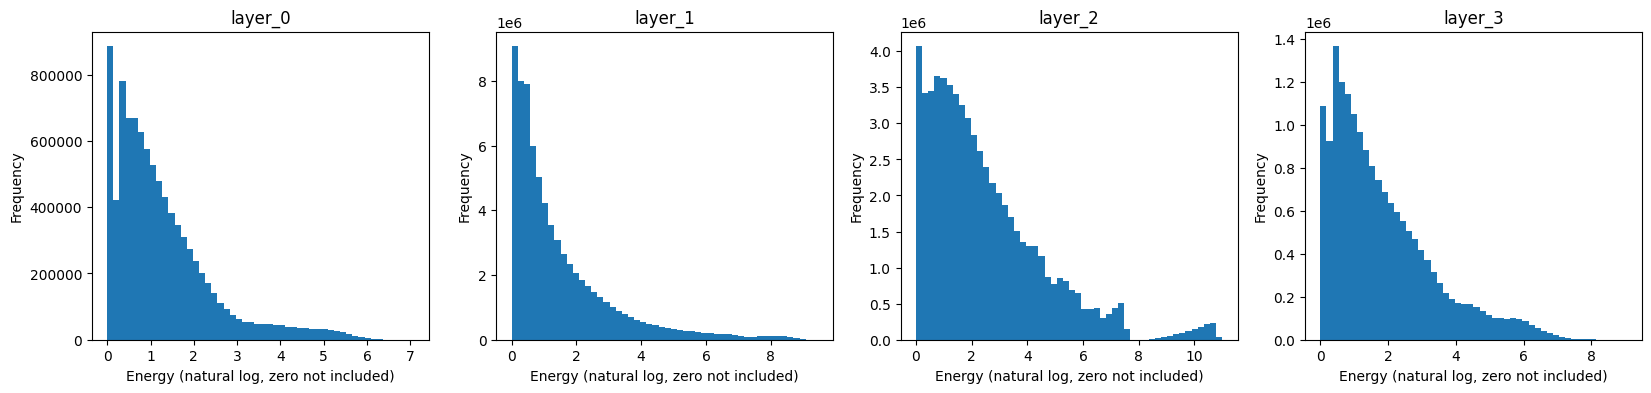

In [12]:
# Energies are scaled; now take the log
# ~14 s
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

for i, layer in enumerate(["layer_0", "layer_1", "layer_2", "layer_3"]):
    print(f"Processing {layer}")
    energies = all_layers[layer][:1000]
    logged = np.log(all_layers[layer] + 1)
    
    axs[i].hist(logged[logged > 0].flatten(), bins=50)
    axs[i].set_title(layer);
    axs[i].set_xlabel("Energy (natural log, zero not included)")
    axs[i].set_ylabel("Frequency");

In [14]:
# Transform energies
# ~20 sec
all_layers_normed = {}
for i, layer in enumerate(["layer_0", "layer_1", "layer_2", "layer_3"]):
    print(f"[{i}] preprocessing {layer}...")

    og_shape = all_layers[layer].shape
    print("    transforming...")
    logged = np.log(all_layers[layer] + 1)
    
    print("    reshaping...")
    all_layers_normed[layer] = logged.reshape(og_shape)
    
    print(f"    normalized")

[0] preprocessing layer_0...
    transforming...
    reshaping...
    normalized
[1] preprocessing layer_1...
    transforming...
    reshaping...
    normalized
[2] preprocessing layer_2...
    transforming...
    reshaping...
    normalized
[3] preprocessing layer_3...
    transforming...
    reshaping...
    normalized


In [15]:
# "overflow" and other keys
for key in ["energy", "overflow", "label"]:
    all_layers_normed[key] = all_layers[key]

### Shuffle things around

In [16]:
# Shuffle things around
# ~2 sec
order = np.random.permutation(3 * N)
for layer in all_layers_normed:
    all_layers_normed[layer] = all_layers_normed[layer][order]

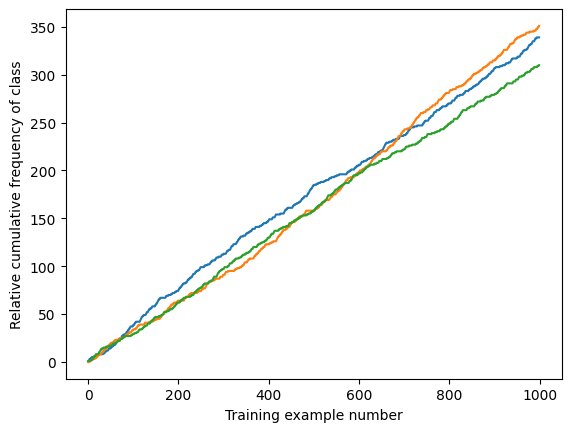

In [17]:
# Plot cumulative frequencies
onehot_labels = np.squeeze(np.eye(3)[all_layers_normed["label"]])
cumsum = np.cumsum(onehot_labels, axis=0)

# Pretty uniform distribution
plt.plot(cumsum[:1000]);
plt.xlabel("Training example number")
plt.ylabel("Relative cumulative frequency of class");

In [18]:
for key in all_layers_normed:
    print(key.ljust(10), all_layers_normed[key].shape)

layer_0    (300000, 4, 16)
layer_1    (300000, 4, 128)
layer_2    (300000, 16, 16)
layer_3    (300000, 16, 8)
energy     (300000, 1)
overflow   (300000, 4)
label      (300000,)


In [19]:
# ~10 sec
np.savez(f"{data_dir}/all_jets_no_transform.npz", **all_layers_normed)

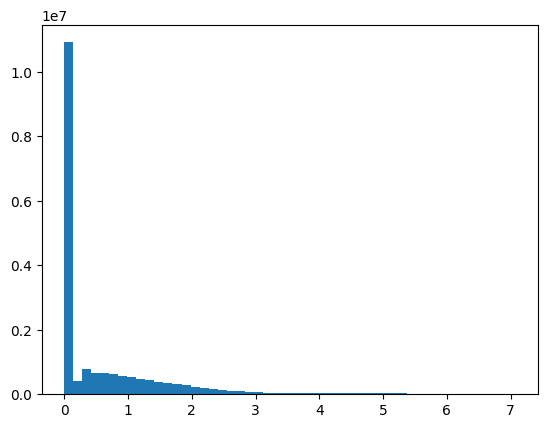

In [23]:
plt.hist(all_layers_normed["layer_0"].flatten(), bins=50);